**Récupération du dataset depuis HuggingFace**

In [2]:
from datasets import Dataset, load_dataset

dataset = load_dataset("mteb/amazon_reviews_multi", split="train")
dataset = dataset.to_pandas()
dataset = Dataset.from_pandas(dataset)

/home/raclax/Documents/M1/S2/outilcorps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/raclax/Documents/M1/S2/outilcorps/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for mteb/amazon_reviews_multi contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/mteb/amazon_reviews_multi
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
# Text pour vérifier que le dataset a bien été récupéré
dataset [105000]

{'id': 'de_0193174',
 'text': 'Geht so.\n\nDie Grösse ist spitze aber die Bügelunterlage ist alles andere als gut.',
 'label': 2,
 'label_text': '2'}

**Mesure de la corrélation et de la p value**

On va mesurer la corrélation entre la lingueur des commentaores et la note qui leur est associé. On peut en effet penser que plus la note est mauvaise, plus le commentaire sera long car lapersonne risquera d'être énervée et avoir beaucoup à dire.

In [5]:
import pandas as pd
import re

df = pd.DataFrame(dataset)

# On tokenise ave les espaces : c'est le plus simle puisque c'est un corpus multilingue
def count_tokens(text):
    tokens = re.findall(r'\b\w+\b', text) 
    return len(tokens)

df['token_count'] = df['text'].apply(count_tokens)

In [6]:
from scipy.stats import spearmanr

correlation, p_value = spearmanr(df['label'], df['token_count'])

print("Coefficient de corrélation de Spearman:", correlation)
print("P-value:", p_value)

Coefficient de corrélation de Spearman: -0.06195171361971975
P-value: 0.0


**Représentation graphique des données**

/home/raclax/Documents/M1/S2/outilcorps/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


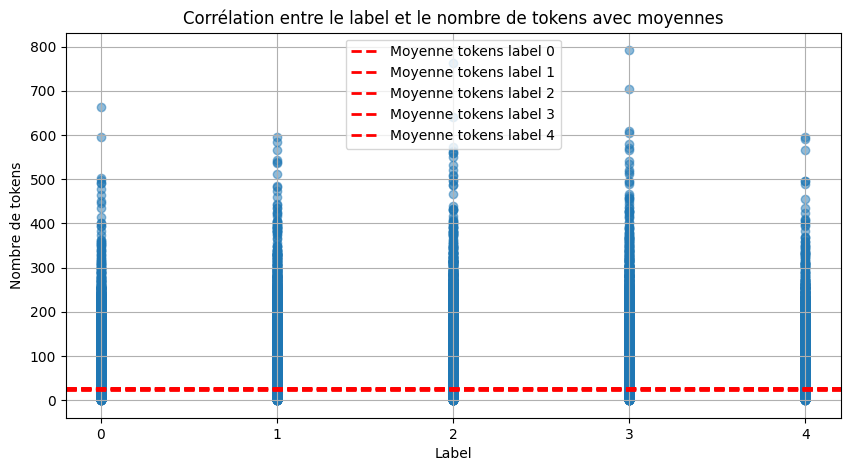

In [7]:
import matplotlib.pyplot as plt

mean_token_counts = df.groupby('label')['token_count'].mean()

# Création du scatter plot
plt.figure(figsize=(10, 5))
plt.scatter(df['label'], df['token_count'], alpha=0.5)

# Ajout des lignes horizontales de moyenne pour chaque label
for label, mean_token_count in mean_token_counts.items():
    plt.axhline(y=mean_token_count, color='r', linestyle='--', linewidth=2, label=f'Moyenne tokens label {label}')

plt.title('Corrélation entre le label et le nombre de tokens avec moyennes')
plt.xlabel('Label')
plt.ylabel('Nombre de tokens')
plt.xticks(ticks=df['label'].unique())  # Assure que tous les labels sont montrés
plt.grid(True)
plt.legend()
plt.show()

In [8]:
print (mean_token_counts)

label
0    25.315875
1    28.396663
2    27.035554
3    25.156146
4    22.272112
Name: token_count, dtype: float64


-> Les moyennes sont équivalantes, il n'y a donc pas de corrélation apparante entre la longueur d'un message et sa note

**Eliminer les outliers**

In [14]:
Q1 = df['token_count'].quantile(0.25)
Q3 = df['token_count'].quantile(0.75)
IQR = Q3 - Q1
df_filtered = df[~((df['token_count'] < (Q1 - 1.5 * IQR)) | (df['token_count'] > (Q3 + 1.5 * IQR)))]

print(df_filtered)

                 id                                               text  label  \
0        de_0203609  Leider nach 1 Jahr kaputt\n\nArmband ist leide...      0   
1        de_0559494  EINS statt ZWEI Akkus!!!\n\nIn der Lieferung w...      0   
2        de_0238777  Achtung Abzocke\n\nEin Stern, weil gar keine g...      0   
3        de_0477884  Zu viel des Guten\n\nDachte, das wären einfach...      0   
4        de_0270868  Qualität sehr schlecht\n\nMeine Kinder haben k...      0   
...             ...                                                ...    ...   
1199995  zh_0336212  买的时候做活动很便宜，效果真是不错，据说是纯天然的，非常滋润。\n\n买的时候做活动很便宜，...      4   
1199996  zh_0053535    雕爷的经典作品推荐啊\n\n从生活的小细节入手，虽然已经过了时代，但是很多细节还是值得我们学习      4   
1199997  zh_0023067       书不错\n\n速度快，质量也好，书的内容新颖，题目还有解析，是一本值得推荐的复习参考书。      4   
1199998  zh_0723826                     全新卡\n\n第一次用这么好的卡，LOL能开到300多FPS      4   
1199999  zh_0895657                 不错。\n\n不错，吹风机很好，给妈妈买的，她说质量很好，风也很大。      4   

        label_text  token_c

**Augmenter les données**

In [18]:
import random
import nltk
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('omw-1.4')

def augment_text(text):
    words = text.split()
    new_words = []
    for word in words:
        synsets = wordnet.synsets(word)
        if synsets:
            syn = random.choice(synsets)
            lemmas = syn.lemmas()
            synonym = random.choice(lemmas).name().replace('_', ' ')
            new_words.append(synonym)
        else:
            new_words.append(word)
    return ' '.join(new_words)

prefixes = ['de', 'fr', 'es', 'zh', 'en', 'ja']
current_id = 10000001

augmented_dataset = []
for index, row in df_filtered.iterrows():
    augmented_text = augment_text(row['text'])
    prefix = random.choice(prefixes)
    augmented_data = {
        'id': f"{prefix}_{current_id}",
        'text': augmented_text,
        'label': row['label'],
        'label_text': str(row['label'])
    }
    augmented_dataset.append(augmented_data)
    current_id += 1

augmented_df = pd.DataFrame(augmented_dataset)

# Concaténation des deux DataFrames
combined_df = pd.concat([df_filtered, augmented_df], ignore_index=True)

len(combined_df)

[nltk_data] Downloading package wordnet to /home/raclax/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/raclax/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


2270906

**Splitter en test et train**

In [19]:
from sklearn.model_selection import train_test_split

#On en garde 20ù pour le test
train, test = train_test_split(combined_df, test_size=0.2)

**Évaluer le corpus avec une métrique adaptée**

**Proposer une autre métrique pour son corpus**